In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from z3 import *

In [2]:
# not quite working yet. Can get a separate circular island for large numbers


fix= np.array([[0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 5],
               [0, 2, 0, 0, 3, 0],
               [0, 0, 0, 0, 0, 0],
               [2, 0, 0, 0, 0, 0],
               [0, 0, 5, 0, 0, 0]])

fix2= np.array([[1, 0, 0, 0, 4, 0, 0, 4, 0, 2],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 2, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 1, 0, 0, 2],
                [1, 0, 0, 0, 0, 3, 0, 0, 0, 0],
                [0, 0, 6, 0, 0, 0, 0, 0, 0, 5],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 2],
                [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [3]:
def neighbours(i,j,N):
    return [[i+x,j+y] for (x,y) in [(-1,0),(0,-1),(1,0),(0,1)] if i+x>=0 and i+x <N and j+y>=0 and j+y <N ]
    
def pr(ans,fix):
    annot = fix.astype('str')
    annot[annot=="0"] =""
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    ax =sns.heatmap(ans !=0,annot=annot,cbar=False,cmap="Greys_r",fmt="",linewidths=1,annot_kws={"size":14},linecolor='k')
    ax.axis("off")
    plt.show()

In [4]:
def solve(fix,tactic):
    start= time.time()
    N = fix.shape[0]
    C = int(np.sum(fix!=0))
    roots = [[i,j,e] for (i,j),e in np.ndenumerate(fix) if e !=0]
    
    s = Tactic(tactic).solver()   
    X = np.array(IntVector('x', N**2),dtype=object).reshape(N,N)
   
    # limit the grid values to 0 (black) or the island
    s += [And(e>= 0  ,e <=C) for (i,j),e in np.ndenumerate(X)]  
    
    # set the island values for each root
    s += [X[a,b] == n+1 for n,[a,b,x] in enumerate(roots)]
    
    # make sure the size of each island is correct
    s += [PbEq([(e==n+1,1) for (i,j),e in np.ndenumerate(X)],x) for n,[a,b,x] in enumerate(roots)]
    
    # islands don't touch
    s += [Implies(e > 0,And([Or(X[x,y]==e,X[x,y]==0) for x,y in neighbours(i,j,N)])) for (i,j),e in np.ndenumerate(X)]
    
    # Define a variable to determine if there is an edge between 2 cells
    edge = {}
    for i in range(N):
        for j in range(N):  
            for (k,l) in neighbours(i,j,N) :
                edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
                s += Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)]==1) 
                
    for i in range(N):
        for j in range(N):  
            for (k,l) in neighbours(i,j,N):
                # Make edges one way to form a tree
                s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1
                # Cells with an edge have the same value
                s +=Implies(edge[(k,l,i,j)] == 1,X[i,j] == X[k,l])
    
    # only one edge into each cell
        for i in range(N):
            for j in range(N):  
                # only one edge into each cell
                s += Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) <=1
                # root cells have no feeds in
                s += Implies(int(fix[i,j]) !=0, Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) == 0)
                # root cells > 1 feed out
                s += Implies(int(fix[i,j]) >1, Sum([edge[(i,j,k,l)] for (k,l) in neighbours(i,j,N) ]) == 1)
                # filled cells have a feed in
                s += Implies(X[i,j] != 0, Or(Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) == 1,int(fix[i,j]) !=0 ))
                # zero cells have no feed in or out
                s += Implies(X[i,j] == 0, Sum([edge[(i,j,k,l)] for (k,l) in neighbours(i,j,N) ]) == 0 )
                s += Implies(X[i,j] == 0, Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) == 0 )
    
    if s.check() == sat:
        m = s.model()
        print("{}: {} Solved in {:.4f} seconds".format(tactic,tactic_description(tactic),time.time()-start))
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        r =  evalu(X)
        pr(r,fix)
        return r
        #display([(v,evalu(edge[v]) for v in edge])
    else:
        print("fail")    

pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 0.4946 seconds


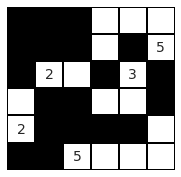

In [5]:
ans = solve(fix,"pqffd")

pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 2.3076 seconds


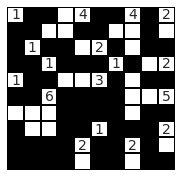

In [6]:
ans = solve(fix2,"pqffd")